# 3D-BPP

## Pre-requisites

In [2]:
import os
from collections import namedtuple
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
from ortools.sat.python import cp_model
from matplotlib import pyplot as plt
from tqdm import tqdm

import config, dataset, main, utils, bins

ModuleNotFoundError: No module named 'dataset'

<IPython.core.display.Javascript object>

In [1]:
%matplotlib notebook
%load_ext autoreload
%load_ext nb_black
%autoreload 2

<IPython.core.display.Javascript object>

In [4]:
plt.style.use("seaborn")
np.random.seed(config.RANDOM_SEED)

<IPython.core.display.Javascript object>

## Pallets and containers

Pallet EUR:

|       |  $L\times W\times H (cm)$   | Load (kg)  |
|:-----:|:--------------------------:|:--------:|
| EUR 1 |  $80\times 120\times 14.5$ |  $2490$  |
| EUR 2 | $120\times 100\times 14.4$ |  $1470$  |
| EUR 3 | $100\times 120\times 14.4$ |  $1920$  |
| EUR 6 |  $80\times 60\times 14.4$  |   $500$  |

Container ISO:

|   |  $L\times W\times H (cm)$  | Load (kg) |
|:-:|:--------------------------:|:--------:|
| 1A | $233\times 1200\times 220$ |  $26480$ |
| 1C |  $233\times 587\times 220$ |  $28180$ |

## Dataset

### Products

In [19]:
product_dataset = dataset.ProductDataset(
    "data/products.pkl",
    config.NUM_PRODUCTS,
    config.MIN_PRODUCT_WIDTH,
    config.MAX_PRODUCT_WIDTH,
    config.MIN_PRODUCT_DEPTH,
    config.MAX_PRODUCT_DEPTH,
    config.MIN_PRODUCT_HEIGHT,
    config.MAX_PRODUCT_HEIGHT,
    config.MIN_PRODUCT_WEIGHT,
    config.MAX_PRODUCT_WEIGHT,
    force_overload=False,
)
product_dataset.products.head()

,width,depth,height,weight,volume
0,284,226,119,25,7637896
1,299,207,137,90,8479341
2,534,372,229,41,45490392
3,295,134,232,31,9170960
4,266,186,178,54,8806728


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


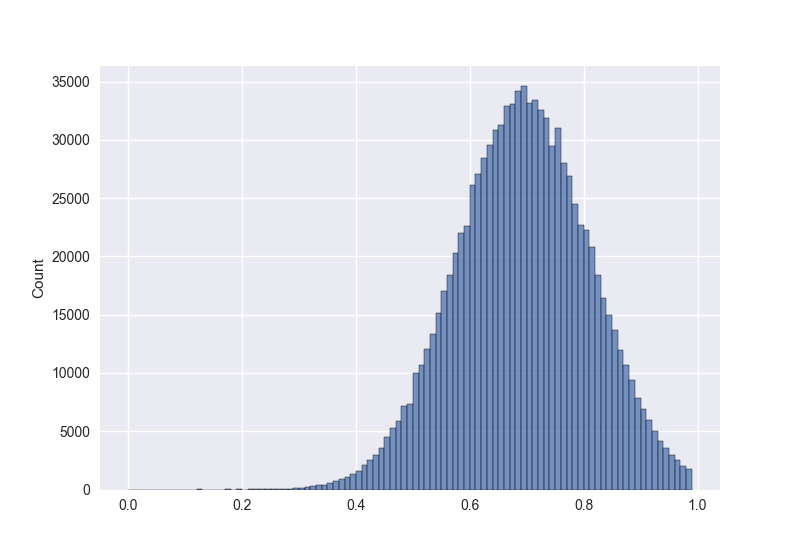

<IPython.core.display.Javascript object>

In [21]:
plt.figure()
sns.histplot(
    product_dataset.products.depth / product_dataset.products.width,
    bins=np.arange(0, 1, 0.01),
)
plt.show()

<IPython.core.display.Javascript object>


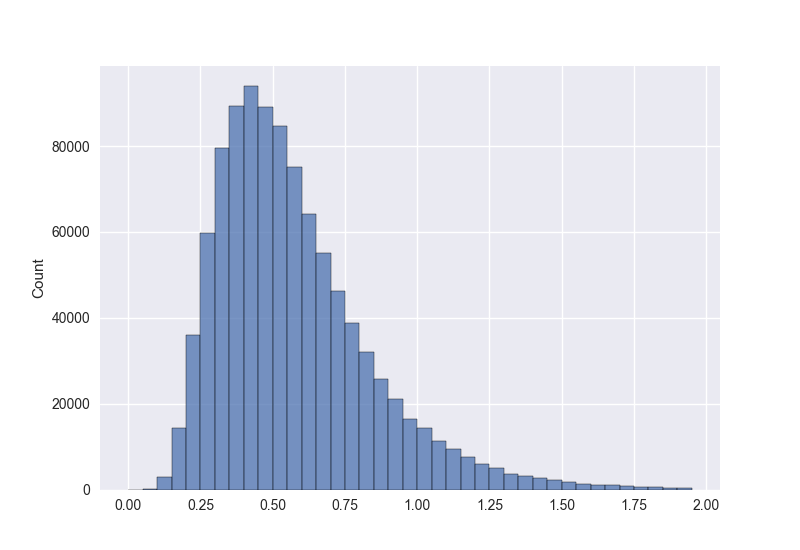

<IPython.core.display.Javascript object>

In [22]:
plt.figure()
sns.histplot(
    product_dataset.products.height / product_dataset.products.width,
    bins=np.arange(0, 2, 0.05),
)
plt.show()

<IPython.core.display.Javascript object>


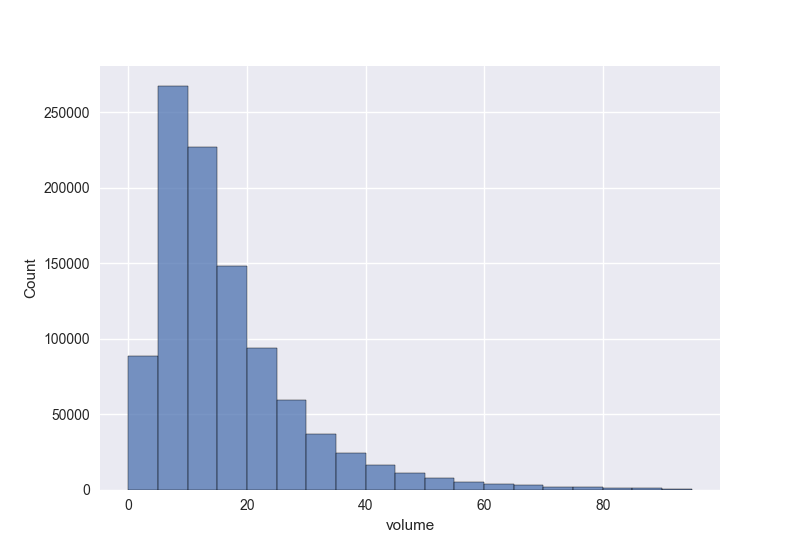

<IPython.core.display.Javascript object>

In [23]:
plt.figure()
sns.histplot(product_dataset.products.volume / 1e6, bins=np.arange(0, 100, 5))
plt.show()

<IPython.core.display.Javascript object>


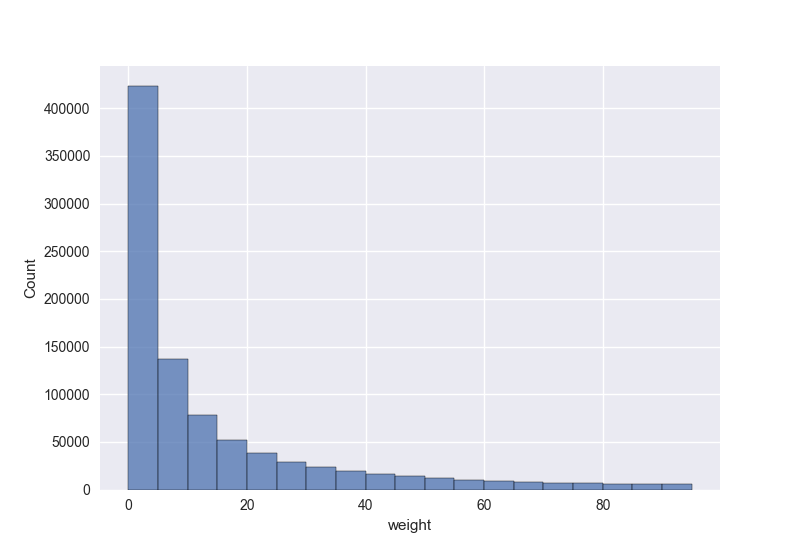

<IPython.core.display.Javascript object>

In [24]:
plt.figure()
sns.histplot(product_dataset.products.weight, bins=np.arange(0, 100, 5))
plt.show()

### Order

In [6]:
ordered_products = 100
order = product_dataset.get_order(ordered_products)
# order = pd.read_csv("data/test_order.csv")
# order = product_dataset.get_dummy_order(ordered_products)
order.head()

,id,width,depth,height,weight,volume
0,121958,193,221,371,2,15824263
1,671155,236,142,437,58,14644744
2,131932,228,139,254,26,8049768
3,365838,267,131,322,11,11262594
4,259178,253,191,580,68,28027340


<IPython.core.display.Javascript object>

## Martello's lower bounds

In [131]:
utils.get_l0_lb(order, config.PALLET_DIMS)

1.0

<IPython.core.display.Javascript object>

In [132]:
utils.get_l1_lb(order, config.PALLET_DIMS)

(0.0, 0.0, 0.0, 0.0)

<IPython.core.display.Javascript object>

In [70]:
utils.get_l2_lb(order, config.PALLET_DIMS)

2500it [00:10, 231.49it/s]
2450it [00:10, 233.15it/s]
2450it [00:10, 234.02it/s]


(1.0, 1.0, 1.0, 1.0)

<IPython.core.display.Javascript object>

## Baseline

In [133]:
bl_order = product_dataset.get_order(20)

<IPython.core.display.Javascript object>

In [138]:
bl_bin_pool = main.main(bl_order, procedure="bl", tlim=20)
bl_bin_pool.get_original_layer_pool().to_dataframe()

2021-08-14 14:45:07.238 | INFO     | main:main:166 - BL procedure starting
2021-08-14 14:45:07.239 | INFO     | main:main:176 - BL iteration 1/1
2021-08-14 14:45:07.242 | DEBUG    | superitems:_gen_single_items_superitems:634 - Generated 20 superitems with a single item
2021-08-14 14:45:07.243 | INFO     | superitems:gen_superitems:618 - Generating horizontal superitems of type 'two-width'
2021-08-14 14:45:07.243 | DEBUG    | superitems:_gen_superitems_horizontal:680 - Generated 0 horizontal superitems with 2 items
2021-08-14 14:45:07.244 | DEBUG    | superitems:_gen_superitems_horizontal:687 - Generated 0 horizontal superitems with 4 items
2021-08-14 14:45:07.244 | INFO     | superitems:gen_superitems:621 - Generating vertical superitems with maximum stacking of 4
2021-08-14 14:45:07.245 | DEBUG    | superitems:_gen_superitems_vertical:765 - Generated 15 wide vertical superitems
2021-08-14 14:45:07.246 | DEBUG    | superitems:_gen_superitems_vertical:767 - Generated 1 deep vertical su

,item,x,y,z,width,depth,height,layer
0,0,481,602,0,213,188,313,0
1,1,532,1,0,300,291,444,0
2,2,704,668,0,317,110,484,0
3,3,245,1,0,287,157,333,0
4,5,1021,602,0,177,174,226,0
5,6,849,0,0,350,287,441,0
6,7,242,397,0,219,205,393,0
7,8,365,302,0,339,84,417,0
8,9,570,443,0,123,159,227,0
9,11,242,602,0,239,159,354,0


<IPython.core.display.Javascript object>

In [ ]:
bl_bin_pool.get_original_layer_pool().describe()

<IPython.core.display.Javascript object>


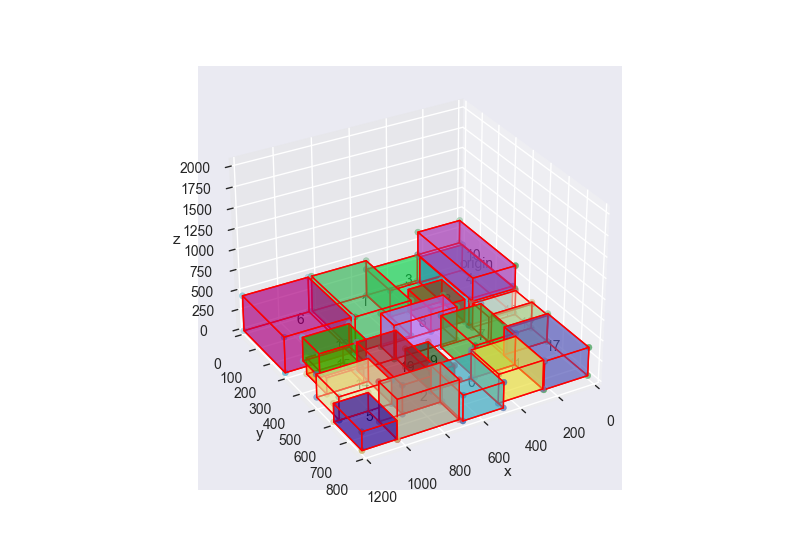

[<Axes3DSubplot:xlabel='x', ylabel='y'>]

<IPython.core.display.Javascript object>

In [139]:
bl_bin_pool.get_original_bin_pool().plot();

<IPython.core.display.Javascript object>


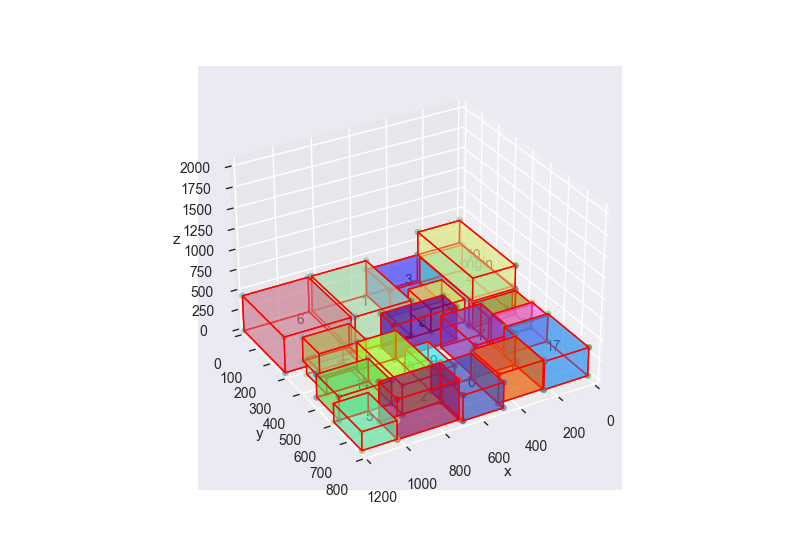

[<Axes3DSubplot:xlabel='x', ylabel='y'>]

<IPython.core.display.Javascript object>

In [140]:
bl_bin_pool.plot();

## Maxrects

In [26]:
mr_bin_pool = main.main(
    order,
    procedure="mr",
    superitems_horizontal=True,
    superitems_horizontal_type="two-width",
)
mr_bin_pool.get_original_layer_pool().to_dataframe()

2021-09-15 19:33:22.615 | INFO     | main:main:169 - MR procedure starting
2021-09-15 19:33:22.616 | INFO     | main:main:179 - MR iteration 1/1
2021-09-15 19:33:22.627 | DEBUG    | superitems:_gen_single_items_superitems:639 - Generated 100 superitems with a single item
2021-09-15 19:33:22.627 | INFO     | superitems:gen_superitems:623 - Generating horizontal superitems of type 'two-width'
2021-09-15 19:33:22.628 | DEBUG    | superitems:_gen_superitems_horizontal:685 - Generated 0 horizontal superitems with 2 items
2021-09-15 19:33:22.629 | DEBUG    | superitems:_gen_superitems_horizontal:692 - Generated 0 horizontal superitems with 4 items
2021-09-15 19:33:22.629 | INFO     | superitems:gen_superitems:626 - Generating vertical superitems with maximum stacking of 4
2021-09-15 19:33:22.631 | DEBUG    | superitems:_gen_superitems_vertical:770 - Generated 80 wide vertical superitems
2021-09-15 19:33:22.632 | DEBUG    | superitems:_gen_superitems_vertical:772 - Generated 24 deep vertical 

,item,x,y,z,width,depth,height,layer
0,33,0,0,0,268,313,456,0
1,45,0,313,0,186,378,351,0
2,58,0,691,0,339,84,417,0
3,40,186,313,0,273,257,325,0
4,52,186,570,0,317,110,484,0
...,...,...,...,...,...,...,...,...
95,92,299,0,0,254,179,448,5
96,51,553,0,0,300,291,444,5
97,56,0,179,0,350,287,441,5
98,57,853,0,0,219,205,393,5


<IPython.core.display.Javascript object>

In [27]:
mr_bin_pool.get_original_layer_pool().describe()

,layer,height,area,volume,2d_density,3d_density
0,0,510.0,803651.0,2.932651e+08,0.837136,0.598989
1,1,580.0,883366.0,3.331470e+08,0.920173,0.598324
2,2,601.0,820530.0,3.343484e+08,0.854719,0.579500
3,3,654.0,834859.0,3.372537e+08,0.869645,0.537165
4,4,363.0,753155.0,2.199760e+08,0.784536,0.631244
5,5,486.0,350715.0,1.522052e+08,0.365328,0.326229
6,Total,3194.0,4446276.0,1.670196e+09,0.771923,0.545242


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


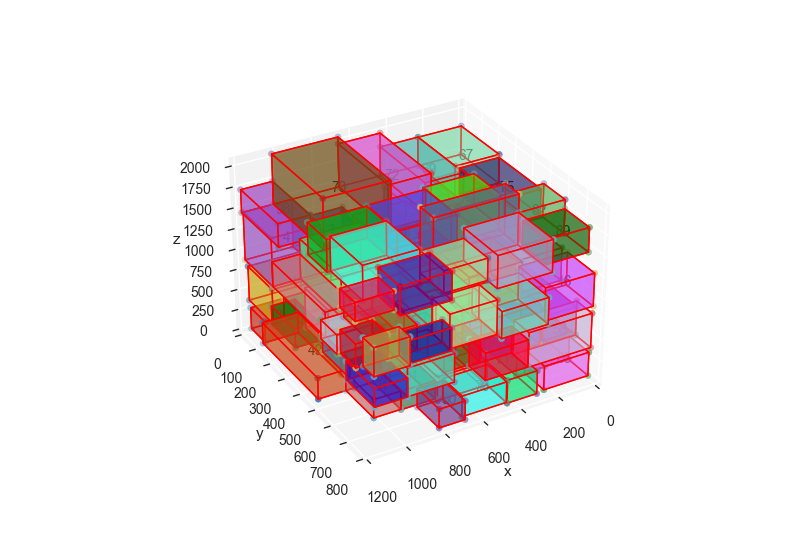

<IPython.core.display.Javascript object>


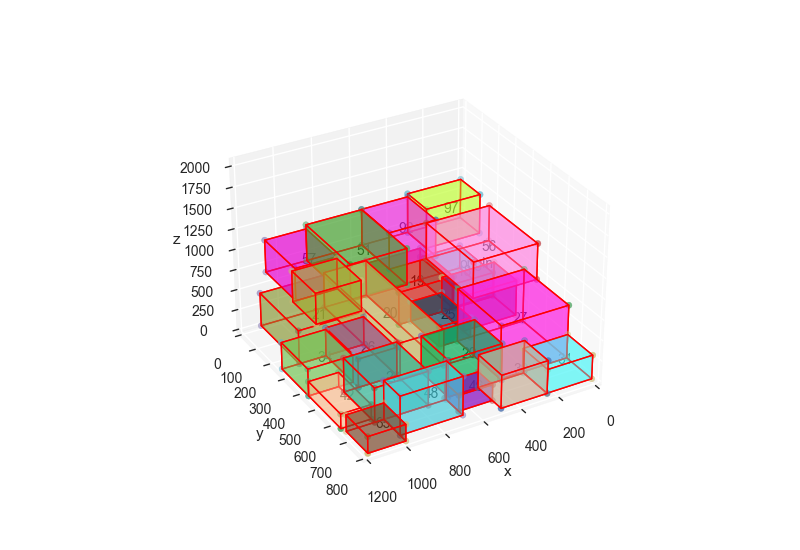

[<Axes3DSubplot:xlabel='x', ylabel='y'>,
 <Axes3DSubplot:xlabel='x', ylabel='y'>]

<IPython.core.display.Javascript object>

In [28]:
mr_bin_pool.get_original_bin_pool().plot()

<IPython.core.display.Javascript object>


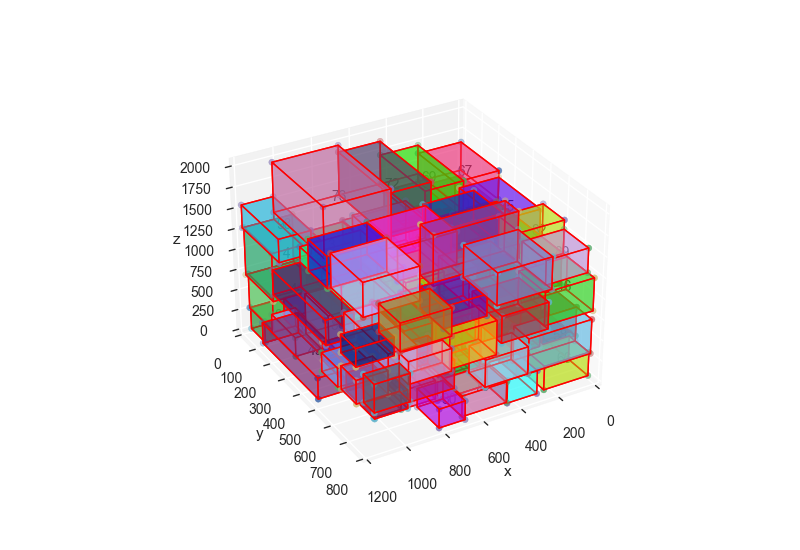

<IPython.core.display.Javascript object>


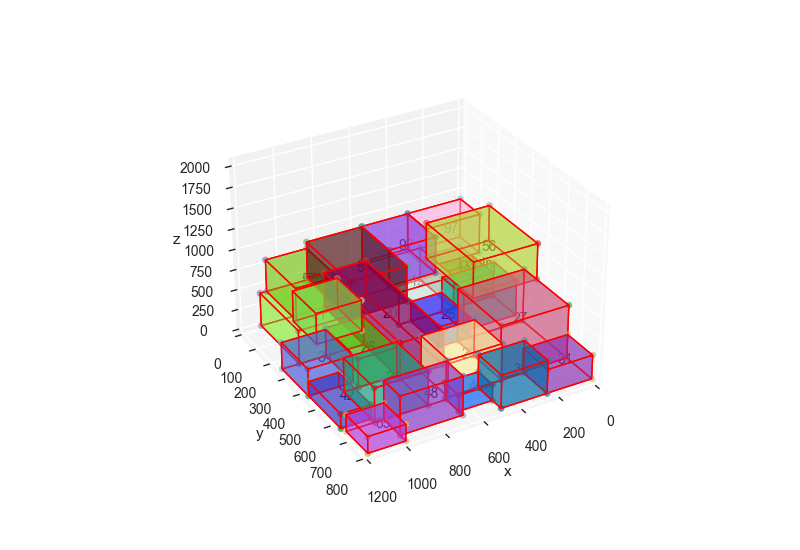

<IPython.core.display.Javascript object>

In [29]:
mr_bin_pool.plot()

## Column generation

In [30]:
cg_bin_pool = main.main(
    order,
    procedure="cg",
    max_iters=1,
    superitems_horizontal=True,
    superitems_horizontal_type="two-width",
    tlim=10,
    cg_use_height_groups=False,
    cg_mr_warm_start=False,
    cg_max_iters=100,
    cg_max_stag_iters=10,
    cg_sp_mr=True,
    cg_sp_np_type="mip",
    cg_sp_p_type="mr",
    cg_return_only_last=False,
)
cg_bin_pool.get_original_layer_pool().to_dataframe()

2021-09-15 19:34:22.257 | INFO     | main:main:169 - CG procedure starting
2021-09-15 19:34:22.258 | INFO     | main:main:179 - CG iteration 1/1
2021-09-15 19:34:22.269 | DEBUG    | superitems:_gen_single_items_superitems:639 - Generated 100 superitems with a single item
2021-09-15 19:34:22.270 | INFO     | superitems:gen_superitems:623 - Generating horizontal superitems of type 'two-width'
2021-09-15 19:34:22.271 | DEBUG    | superitems:_gen_superitems_horizontal:685 - Generated 0 horizontal superitems with 2 items
2021-09-15 19:34:22.272 | DEBUG    | superitems:_gen_superitems_horizontal:692 - Generated 0 horizontal superitems with 4 items
2021-09-15 19:34:22.272 | INFO     | superitems:gen_superitems:626 - Generating vertical superitems with maximum stacking of 4
2021-09-15 19:34:22.274 | DEBUG    | superitems:_gen_superitems_vertical:770 - Generated 80 wide vertical superitems
2021-09-15 19:34:22.276 | DEBUG    | superitems:_gen_superitems_vertical:772 - Generated 24 deep vertical 

2021-09-15 19:34:23.146 | DEBUG    | column_generation:master_problem:123 - RMP constraints: 100
2021-09-15 19:34:23.148 | DEBUG    | column_generation:master_problem:125 - RMP iterations: 89
2021-09-15 19:34:23.149 | INFO     | column_generation:master_problem:131 - RMP solved
2021-09-15 19:34:23.150 | DEBUG    | column_generation:master_problem:135 - RMP alphas: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

2021-09-15 19:34:23.781 | DEBUG    | column_generation:master_problem:137 - RMP solution not feasible (at least one alpha value is not binary)
2021-09-15 19:34:23.782 | DEBUG    | column_generation:master_problem:141 - RMP objective: 3938.0000000000005
2021-09-15 19:34:23.783 | DEBUG    | column_generation:master_problem:146 - RMP duals: [  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.  323.    0.    0.    0.    0.    0.  441.    0.    0.    0.
   0.    0.  349.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.  325.  283.5   0.    0.    0.    0.    0.    0.
  13.5   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.  289.    0.    0.    0.  231.    0.
   0.    0.    0.  313.    0.  387.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.  290.    0.    0.    0.  330.    0.  363.
   0.    0.    0.    0. ]
2021-09-15 19:34:23.784 | DEBUG    | column_generation:mas

2021-09-15 19:34:24.390 | DEBUG    | column_generation:master_problem:150 - RMP time: 0.277
2021-09-15 19:34:24.393 | DEBUG    | column_generation:column_generation:654 - CG stagnation 4/10
2021-09-15 19:34:24.393 | INFO     | column_generation:pricing_problem_maxrects:160 - SP-MR starting computation
2021-09-15 19:34:24.397 | DEBUG    | maxrects:maxrects_single_layer_online:138 - MR-SL-Online starting
2021-09-15 19:34:24.399 | DEBUG    | maxrects:maxrects_single_layer_online:147 - MR-SL-Online 36 non-zero duals to place
2021-09-15 19:34:24.415 | DEBUG    | maxrects:maxrects_single_layer_online:196 - MR-SL-Online generated a new layer with 17 superitems (of which 12 with non-zero dual) and 0.44136730684488834 3D density
2021-09-15 19:34:24.416 | DEBUG    | column_generation:pricing_problem_maxrects:166 - SP-MR solved
2021-09-15 19:34:24.417 | DEBUG    | column_generation:pricing_problem_maxrects:170 - SP-MR time: 0.02260303497314453
2021-09-15 19:34:24.418 | INFO     | column_generatio

2021-09-15 19:34:25.001 | DEBUG    | column_generation:master_problem:150 - RMP time: 0.278
2021-09-15 19:34:25.006 | DEBUG    | column_generation:column_generation:654 - CG stagnation 6/10
2021-09-15 19:34:25.007 | INFO     | column_generation:pricing_problem_maxrects:160 - SP-MR starting computation
2021-09-15 19:34:25.011 | DEBUG    | maxrects:maxrects_single_layer_online:138 - MR-SL-Online starting
2021-09-15 19:34:25.014 | DEBUG    | maxrects:maxrects_single_layer_online:147 - MR-SL-Online 44 non-zero duals to place
2021-09-15 19:34:25.030 | DEBUG    | maxrects:maxrects_single_layer_online:196 - MR-SL-Online generated a new layer with 17 superitems (of which 14 with non-zero dual) and 0.4742106267197327 3D density
2021-09-15 19:34:25.031 | DEBUG    | column_generation:pricing_problem_maxrects:166 - SP-MR solved
2021-09-15 19:34:25.031 | DEBUG    | column_generation:pricing_problem_maxrects:170 - SP-MR time: 0.02365899085998535
2021-09-15 19:34:25.032 | INFO     | column_generation

2021-09-15 19:34:25.631 | DEBUG    | column_generation:master_problem:150 - RMP time: 0.284
2021-09-15 19:34:25.635 | DEBUG    | column_generation:column_generation:654 - CG stagnation 8/10
2021-09-15 19:34:25.635 | INFO     | column_generation:pricing_problem_maxrects:160 - SP-MR starting computation
2021-09-15 19:34:25.639 | DEBUG    | maxrects:maxrects_single_layer_online:138 - MR-SL-Online starting
2021-09-15 19:34:25.642 | DEBUG    | maxrects:maxrects_single_layer_online:147 - MR-SL-Online 53 non-zero duals to place
2021-09-15 19:34:25.657 | DEBUG    | maxrects:maxrects_single_layer_online:196 - MR-SL-Online generated a new layer with 18 superitems (of which 16 with non-zero dual) and 0.36033551800100705 3D density
2021-09-15 19:34:25.658 | DEBUG    | column_generation:pricing_problem_maxrects:166 - SP-MR solved
2021-09-15 19:34:25.658 | DEBUG    | column_generation:pricing_problem_maxrects:170 - SP-MR time: 0.02237391471862793
2021-09-15 19:34:25.659 | INFO     | column_generatio

2021-09-15 19:34:26.274 | DEBUG    | column_generation:master_problem:150 - RMP time: 0.299
2021-09-15 19:34:26.279 | DEBUG    | column_generation:column_generation:654 - CG stagnation 10/10
2021-09-15 19:34:26.279 | ERROR    | column_generation:column_generation:658 - CG exiting for stagnation
2021-09-15 19:34:26.283 | INFO     | layers:filter_layers:483 - Filtering 111 generated layers
2021-09-15 19:34:26.288 | DEBUG    | layers:filter_layers:485 - Remaining 2 layers after discarding by 0.5 density
2021-09-15 19:34:26.290 | DEBUG    | layers:filter_layers:489 - Remaining 2 layers after discarding by coverage (all: 3, single: 3)
2021-09-15 19:34:26.314 | DEBUG    | maxrects:maxrects_single_layer_offline:88 - MR-SL-Offline starting
2021-09-15 19:34:26.315 | DEBUG    | maxrects:maxrects_single_layer_offline:94 - MR-SL-Offline [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]/14 superitems to place
2021-09-15 19:34:26.323 | ERROR    | layers:remove_duplicated_items:459 - After removing duplica

,item,x,y,z,width,depth,height,layer
0,29,0,22,0,286,162,450,0
1,76,5,18,450,275,171,380,0
2,18,29,0,830,228,207,292,0
3,4,16,8,1122,253,191,580,0
4,27,0,246,0,366,256,654,0
...,...,...,...,...,...,...,...,...
95,34,244,0,0,231,176,329,3
96,22,244,176,0,294,136,440,3
97,61,475,0,0,239,159,354,3
98,94,341,312,0,231,128,345,3


<IPython.core.display.Javascript object>

In [31]:
cg_bin_pool.get_original_layer_pool().describe()

,layer,height,area,volume,2d_density,3d_density
0,0,1702.0,837966.0,9.786522e+08,0.872881,0.598960
1,1,289.0,828939.0,2.121444e+08,0.863478,0.764650
2,2,519.0,860836.0,3.328284e+08,0.896704,0.668008
3,3,440.0,422781.0,1.465704e+08,0.440397,0.346994
4,Total,2950.0,2950522.0,1.670196e+09,0.768365,0.594653


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


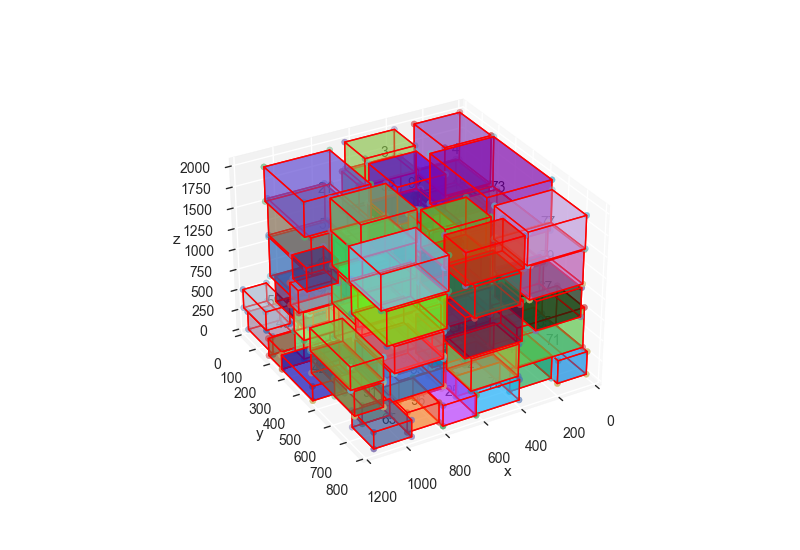

<IPython.core.display.Javascript object>


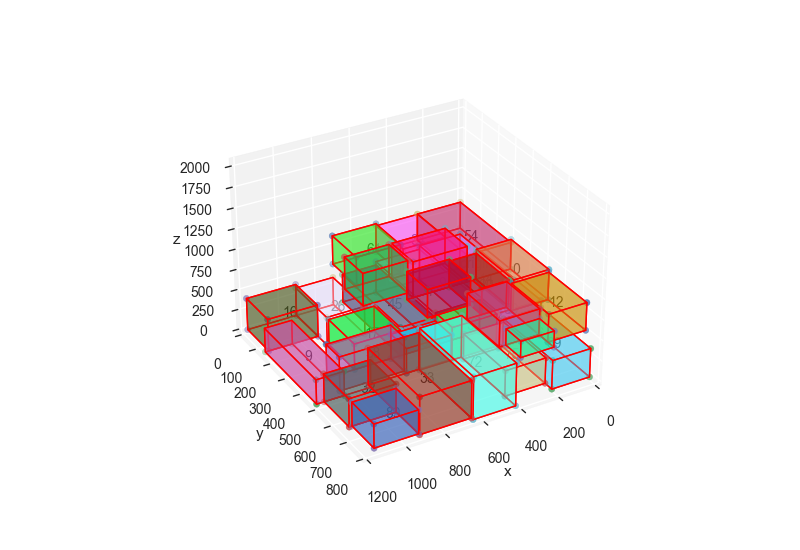

[<Axes3DSubplot:xlabel='x', ylabel='y'>,
 <Axes3DSubplot:xlabel='x', ylabel='y'>]

<IPython.core.display.Javascript object>

In [32]:
cg_bin_pool.get_original_bin_pool().plot()

<IPython.core.display.Javascript object>


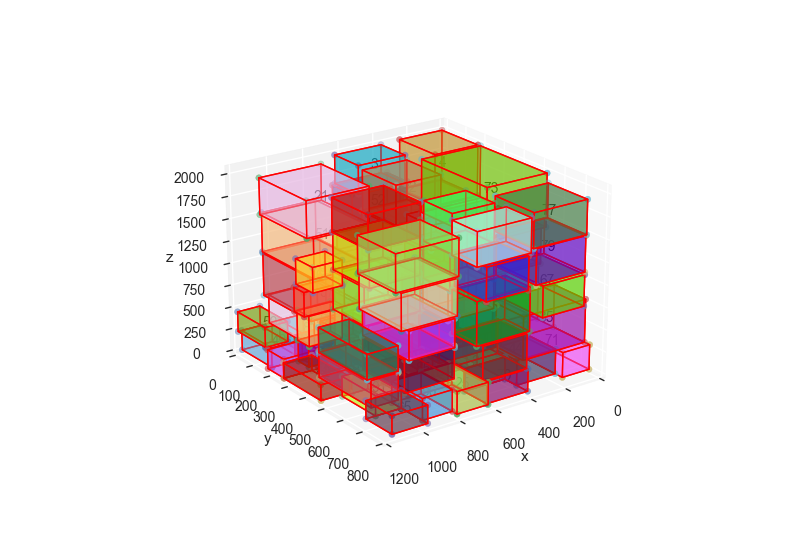

<IPython.core.display.Javascript object>


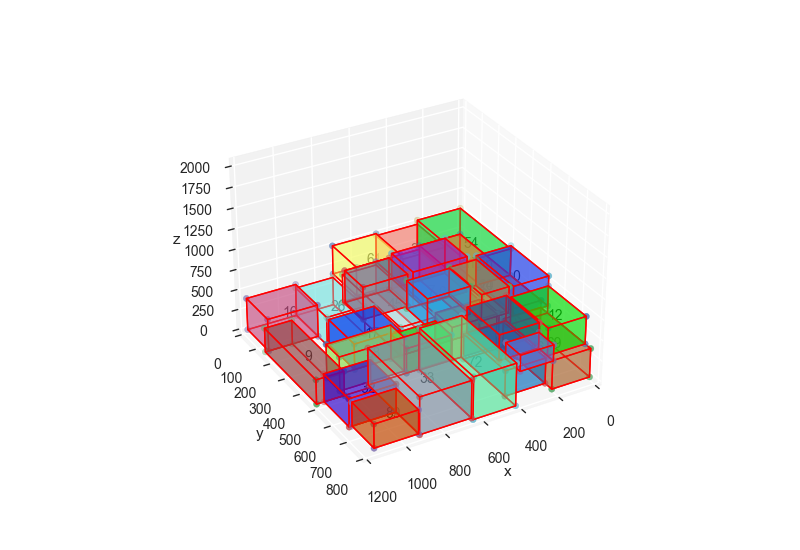

[<Axes3DSubplot:xlabel='x', ylabel='y'>,
 <Axes3DSubplot:xlabel='x', ylabel='y'>]

<IPython.core.display.Javascript object>

In [33]:
cg_bin_pool.plot()